# Inverse NSFW
Slightly modifify the image to chagne it's open NSFW score.
The change is usually visually indistinguishable.

In [1]:
# this is ugly, but this ipynb and the open_nsfw used to be one file.
# We want to import all those theano, lasagne, numpy and a lot of variables.
from open_nsfw import *
from open_nsfw import __resize_image
from IPython.display import display

Using gpu device 0: GeForce GTX 965M (CNMeM is disabled, cuDNN 4007)


In [2]:
# source image file
img_fn = "img/the_scream.jpg"
img_fn = "img/starry_night.jpg"

# CC-BY images from flickr that has high open nsfw score
#img_fn = "https://farm1.staticflickr.com/40/92101780_62da7c8d3a_o_d.jpg"
#img_fn = "https://farm1.staticflickr.com/53/132063430_ec0e7c5988_z_d.jpg"

# output file prefix
output_fn = "output/"+img_fn.split("/")[-1].split(".")[0]

from urllib.request import urlopen
if img_fn.startswith('https://') or img_fn.startswith('http://'):
    img_fn = Image.open(urlopen(img_fn))

# direction: 0 = SFW -> NSFW, 1 = NSFW -> SFW
direction = 0   # towards NSFW
# direction = 1 # towards SFW




In [3]:
# A convolution neural network intend to replace the jpeg encoding/decoding procees.
# it also act as an adversary of the inverse NSFW network

def build_jpg_net(input_var):
    _0 = _ = InputLayer(input_var=input_var, shape=(None,3,256,256))
    _ = Conv2DLayer(_, num_filters=64, filter_size=5, pad="same", 
                                             nonlinearity=lasagne.nonlinearities.rectify)
    _ = Conv2DLayer(_, num_filters=64, filter_size=5, pad="same", 
                                             nonlinearity=lasagne.nonlinearities.rectify)
    _ = Conv2DLayer(_, num_filters=3, filter_size=5, pad="same", 
                                             nonlinearity=lasagne.nonlinearities.linear)
    _ = lasagne.layers.ElemwiseSumLayer([_0, _])
    _ = lasagne.layers.SliceLayer(_, indices=slice(16, 224+16), axis=2)
    _ = lasagne.layers.SliceLayer(_, indices=slice(16, 224+16), axis=3)
    return _

In [4]:
# jpg network's input_Var and model
jpg_input_var = T.tensor4()
jpg_model = build_jpg_net(jpg_input_var)

# load and process src image
pimg = process(__resize_image(img_fn))
# put it into a theano.shared memory
input_image = theano.shared(pimg)
# the image is used as the input of the jpg network
jpg_output = lasagne.layers.get_output(jpg_model, input_image, deterministic=True)

# Compose the jpg network and nsfw network in order to compute an approximated nsfw score.
# The prefix _nsfw is used to indicate that it is just an approximation of nfsw score,
# becuase the approximated jpeg encoder as input, not the real nsfw score 
_nsfw_output = lasagne.layers.get_output (nsfw_model, jpg_output, deterministic=True)
_nsfw_fn = theano.function([], _nsfw_output)

# the loss function depends on direction. 
_nsfw_loss = _nsfw_output[0][1]  # NSFW score
if direction == 0:
    _nsfw_loss = 1 - _nsfw_loss

# Use adam to minimize _nfsw_loss.  
_nsfw_params = [input_image]
_nsfw_updates = lasagne.updates.adam(_nsfw_loss, _nsfw_params)
_nsfw_train_fn = theano.function([], _nsfw_loss, updates=_nsfw_updates)

# The loss function of jpg model. 
# Our target is expected to be the jpeg encoded and then decode src image.
# However, the output is not accurate enough to replace the jpeg process.
# Thus, an adversary loss, 1-_nsfw_loss, is added, 
# so that we hope the inaccuracy won't help the inverse nsfw process. 
jpg_target_var = T.tensor4()
jpg_loss = lasagne.objectives.squared_error(jpg_output, jpg_target_var).mean() + 4*(1 - _nsfw_loss)
jpg_params = lasagne.layers.get_all_params(jpg_model, trainable=True)
jpg_updates = lasagne.updates.adam(jpg_loss, jpg_params)
jpg_train_fn = theano.function([jpg_target_var], [jpg_loss, jpg_output], updates=jpg_updates)

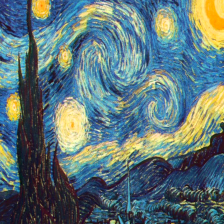

i=0, jpg_loss=294.50073


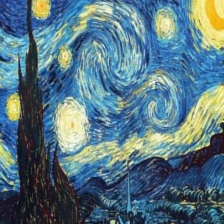

i=100, jpg_loss=73.43977


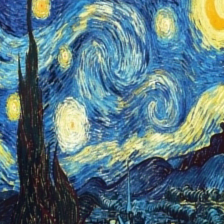

i=200, jpg_loss=64.38681


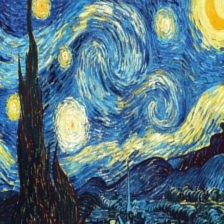

i=300, jpg_loss=61.37110


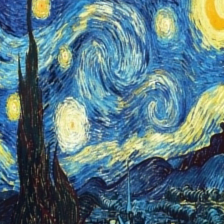

i=400, jpg_loss=60.19306


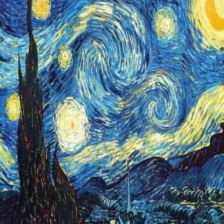

i=500, jpg_loss=58.37243


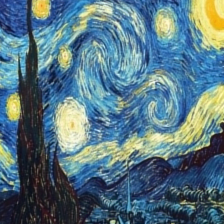

i=600, jpg_loss=57.18929


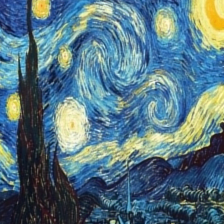

i=700, jpg_loss=56.13109


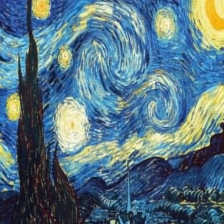

i=800, jpg_loss=55.85510


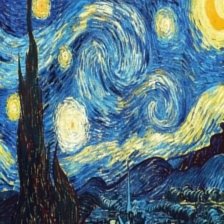

i=900, jpg_loss=54.16871


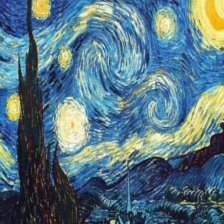

i=1000, jpg_loss=53.19982


In [5]:
# Train the CNN "jpeg encoder" first. Otherwise, it only produce some random output. 
# We only need to mimize the jpeg loss and probably should do so. 
# But the -_nsfw_loss might not hurt.
for i in range(1001):
    jpg_target = crop(make_jpg(input_image.get_value()))
    l_jpg, jpg = jpg_train_fn(jpg_target)
    if i%100 == 0:
        jpg_img = Image.fromarray(deprocess(jpg))
        display(jpg_img)
        jpg_img.save('{}-jpg-{}.png'.format(output_fn, i))
        print("i={}, jpg_loss={:.5f}".format(i, float(l_jpg)))

In [6]:
# Check the NSFW score before the process 
jpg_target = crop(make_jpg(input_image.get_value()))
score = nsfw_score_fn(jpg_target)
print("initial NSFW score=%.5f, approximated NSFW score=%.5f"%(score, _nsfw_fn()[0][1]))

initial NSFW score=0.00174, approximated NSFW score=0.00171


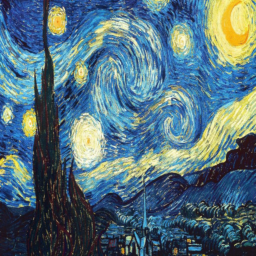

i=0, score=0.00174, _nsfw_loss=0.99819, jpg_loss=53.20462, max_norm=0.000000, L2_norm=0.000000
i=100, score=0.01017, _nsfw_loss=0.99565, jpg_loss=52.53063, max_norm=0.115051, L2_norm=26.564913
i=200, score=0.00963, _nsfw_loss=0.98659, jpg_loss=51.51729, max_norm=0.288879, L2_norm=71.085230
i=300, score=0.00957, _nsfw_loss=0.96084, jpg_loss=50.83823, max_norm=0.502062, L2_norm=127.991005
i=400, score=0.00977, _nsfw_loss=0.91507, jpg_loss=50.68307, max_norm=0.722595, L2_norm=185.421385
i=500, score=0.00915, _nsfw_loss=0.85821, jpg_loss=49.58559, max_norm=0.946701, L2_norm=237.977710
i=600, score=0.01404, _nsfw_loss=0.80139, jpg_loss=49.48164, max_norm=1.141281, L2_norm=287.139380
i=700, score=0.05115, _nsfw_loss=0.76411, jpg_loss=49.21350, max_norm=1.351273, L2_norm=333.428989
i=800, score=0.07545, _nsfw_loss=0.78335, jpg_loss=48.54345, max_norm=1.621758, L2_norm=370.925005
i=900, score=0.07742, _nsfw_loss=0.75152, jpg_loss=48.21856, max_norm=1.766375, L2_norm=404.121404


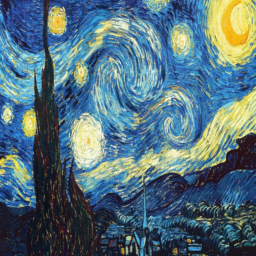

i=1000, score=0.08034, _nsfw_loss=0.79150, jpg_loss=47.48057, max_norm=1.888832, L2_norm=436.792160
i=1100, score=0.08397, _nsfw_loss=0.82879, jpg_loss=46.72858, max_norm=2.014236, L2_norm=464.744621
i=1200, score=0.09347, _nsfw_loss=0.88294, jpg_loss=46.08059, max_norm=2.180725, L2_norm=485.824058
i=1300, score=0.09490, _nsfw_loss=0.86096, jpg_loss=44.76340, max_norm=2.410721, L2_norm=504.288592
i=1400, score=0.11758, _nsfw_loss=0.87421, jpg_loss=44.17874, max_norm=2.589493, L2_norm=523.115576
i=1500, score=0.13286, _nsfw_loss=0.85518, jpg_loss=43.96869, max_norm=2.734268, L2_norm=542.338398
i=1600, score=0.14412, _nsfw_loss=0.86037, jpg_loss=42.82883, max_norm=2.847305, L2_norm=562.213538
i=1700, score=0.17671, _nsfw_loss=0.83540, jpg_loss=42.48346, max_norm=2.945358, L2_norm=583.689049
i=1800, score=0.19691, _nsfw_loss=0.80366, jpg_loss=41.81082, max_norm=3.081764, L2_norm=606.357619
i=1900, score=0.21581, _nsfw_loss=0.84008, jpg_loss=41.49070, max_norm=3.209595, L2_norm=629.055666


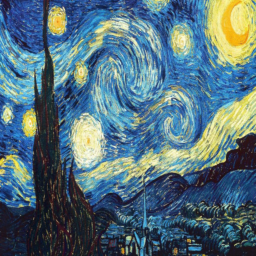

i=2000, score=0.25010, _nsfw_loss=0.82130, jpg_loss=40.80704, max_norm=3.334503, L2_norm=651.789484
i=2100, score=0.30109, _nsfw_loss=0.82018, jpg_loss=39.99289, max_norm=3.494711, L2_norm=674.775611
i=2200, score=0.33217, _nsfw_loss=0.78739, jpg_loss=40.35254, max_norm=3.641197, L2_norm=697.593587
i=2300, score=0.37041, _nsfw_loss=0.79464, jpg_loss=39.86021, max_norm=3.778536, L2_norm=720.098170
i=2400, score=0.39303, _nsfw_loss=0.81025, jpg_loss=39.26820, max_norm=3.937330, L2_norm=743.214681
i=2500, score=0.42467, _nsfw_loss=0.79150, jpg_loss=39.09837, max_norm=4.099134, L2_norm=766.671947
i=2600, score=0.45629, _nsfw_loss=0.79405, jpg_loss=38.71455, max_norm=4.245472, L2_norm=789.157027
i=2700, score=0.46885, _nsfw_loss=0.80851, jpg_loss=38.49532, max_norm=4.381680, L2_norm=809.080690
i=2800, score=0.46988, _nsfw_loss=0.85086, jpg_loss=37.40176, max_norm=4.506084, L2_norm=827.886541
i=2900, score=0.50059, _nsfw_loss=0.82884, jpg_loss=37.64869, max_norm=4.618782, L2_norm=845.668338


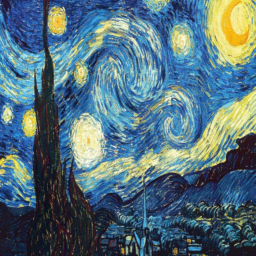

i=3000, score=0.54203, _nsfw_loss=0.82681, jpg_loss=37.44407, max_norm=4.732079, L2_norm=863.689433
i=3100, score=0.52077, _nsfw_loss=0.80130, jpg_loss=37.48273, max_norm=4.829750, L2_norm=881.137688
i=3200, score=0.52517, _nsfw_loss=0.80287, jpg_loss=36.96200, max_norm=4.944557, L2_norm=898.192003
i=3300, score=0.55269, _nsfw_loss=0.80986, jpg_loss=36.92854, max_norm=5.068741, L2_norm=914.801823
i=3400, score=0.58744, _nsfw_loss=0.82584, jpg_loss=36.31187, max_norm=5.194771, L2_norm=930.926555
i=3500, score=0.62174, _nsfw_loss=0.79899, jpg_loss=36.58201, max_norm=5.340439, L2_norm=945.687746
i=3600, score=0.65150, _nsfw_loss=0.82192, jpg_loss=36.01393, max_norm=5.452232, L2_norm=959.903218
i=3700, score=0.62993, _nsfw_loss=0.84552, jpg_loss=39.12304, max_norm=5.515717, L2_norm=973.680838
i=3800, score=0.67126, _nsfw_loss=0.64537, jpg_loss=38.65371, max_norm=5.579903, L2_norm=987.036917
i=3900, score=0.70158, _nsfw_loss=0.84558, jpg_loss=35.56341, max_norm=5.663368, L2_norm=999.269921


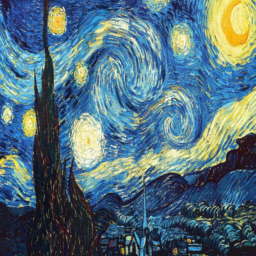

i=4000, score=0.70640, _nsfw_loss=0.79850, jpg_loss=35.25505, max_norm=5.761812, L2_norm=1012.101743
i=4100, score=0.73187, _nsfw_loss=0.81904, jpg_loss=34.60406, max_norm=5.861687, L2_norm=1024.220313
i=4200, score=0.77272, _nsfw_loss=0.81395, jpg_loss=35.49462, max_norm=5.965363, L2_norm=1036.628731
i=4300, score=0.78356, _nsfw_loss=0.74869, jpg_loss=34.22776, max_norm=6.064018, L2_norm=1048.647879
i=4400, score=0.80558, _nsfw_loss=0.80600, jpg_loss=34.43508, max_norm=6.159302, L2_norm=1060.046815
i=4500, score=0.79607, _nsfw_loss=0.78032, jpg_loss=34.34738, max_norm=6.222069, L2_norm=1071.108246
i=4600, score=0.81930, _nsfw_loss=0.84230, jpg_loss=34.28830, max_norm=6.289284, L2_norm=1082.092186
i=4700, score=0.81837, _nsfw_loss=0.82712, jpg_loss=33.93307, max_norm=6.396687, L2_norm=1093.410604
i=4800, score=0.81269, _nsfw_loss=0.74028, jpg_loss=35.58182, max_norm=6.511322, L2_norm=1105.428933
i=4900, score=0.82095, _nsfw_loss=0.76939, jpg_loss=35.01344, max_norm=6.604073, L2_norm=11

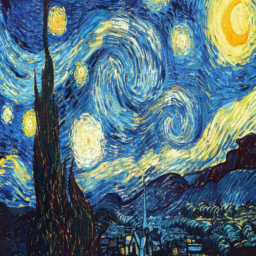

i=5000, score=0.82416, _nsfw_loss=0.80319, jpg_loss=33.77617, max_norm=6.671152, L2_norm=1130.723828
i=5100, score=0.84894, _nsfw_loss=0.76384, jpg_loss=36.19436, max_norm=6.777435, L2_norm=1143.479066
i=5200, score=0.84214, _nsfw_loss=0.74278, jpg_loss=35.46488, max_norm=6.914253, L2_norm=1156.576251
i=5300, score=0.84824, _nsfw_loss=0.74006, jpg_loss=34.61994, max_norm=7.054880, L2_norm=1170.120881
i=5400, score=0.85277, _nsfw_loss=0.80127, jpg_loss=34.05753, max_norm=7.207033, L2_norm=1184.167904
i=5500, score=0.86939, _nsfw_loss=0.78133, jpg_loss=34.30355, max_norm=7.356699, L2_norm=1197.902177
i=5600, score=0.88776, _nsfw_loss=0.85811, jpg_loss=34.33660, max_norm=7.485718, L2_norm=1209.521031
i=5700, score=0.88769, _nsfw_loss=0.75924, jpg_loss=34.03397, max_norm=7.585964, L2_norm=1220.154550
i=5800, score=0.88916, _nsfw_loss=0.84681, jpg_loss=33.84031, max_norm=7.649851, L2_norm=1230.150092
i=5900, score=0.90769, _nsfw_loss=0.86275, jpg_loss=35.35039, max_norm=7.688770, L2_norm=12

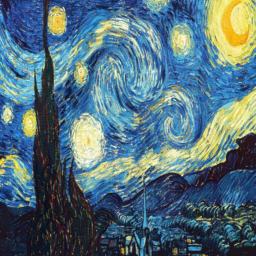

i=6000, score=0.90507, _nsfw_loss=0.82999, jpg_loss=33.96075, max_norm=7.725183, L2_norm=1248.892109
i=6100, score=0.91416, _nsfw_loss=0.80476, jpg_loss=32.70333, max_norm=7.803015, L2_norm=1258.037758
i=6200, score=0.91147, _nsfw_loss=0.81310, jpg_loss=35.61841, max_norm=7.908606, L2_norm=1268.225828
i=6300, score=0.91432, _nsfw_loss=0.77851, jpg_loss=34.40357, max_norm=8.006689, L2_norm=1279.061472
i=6400, score=0.92917, _nsfw_loss=0.81333, jpg_loss=33.04834, max_norm=8.084288, L2_norm=1289.967829
i=6500, score=0.92712, _nsfw_loss=0.72141, jpg_loss=34.12864, max_norm=8.169376, L2_norm=1301.256124
i=6600, score=0.94670, _nsfw_loss=0.81043, jpg_loss=34.19180, max_norm=8.336536, L2_norm=1313.160976
i=6700, score=0.95059, _nsfw_loss=0.69730, jpg_loss=37.09927, max_norm=8.484379, L2_norm=1324.795220
i=6800, score=0.94673, _nsfw_loss=0.79666, jpg_loss=34.12941, max_norm=8.618511, L2_norm=1336.221913
i=6900, score=0.95430, _nsfw_loss=0.77352, jpg_loss=33.71371, max_norm=8.742298, L2_norm=13

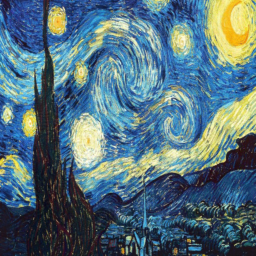

i=7000, score=0.95742, _nsfw_loss=0.78038, jpg_loss=34.47594, max_norm=8.858700, L2_norm=1358.767042
i=7100, score=0.96427, _nsfw_loss=0.75439, jpg_loss=34.22793, max_norm=8.968838, L2_norm=1369.472389
i=7200, score=0.96848, _nsfw_loss=0.75854, jpg_loss=33.67015, max_norm=9.085339, L2_norm=1379.900857
i=7300, score=0.97222, _nsfw_loss=0.75176, jpg_loss=34.82710, max_norm=9.215340, L2_norm=1390.921502
i=7400, score=0.97265, _nsfw_loss=0.75896, jpg_loss=34.06230, max_norm=9.318901, L2_norm=1402.376777
i=7500, score=0.97591, _nsfw_loss=0.70311, jpg_loss=36.11216, max_norm=9.390541, L2_norm=1413.910623
i=7600, score=0.97575, _nsfw_loss=0.78112, jpg_loss=34.27825, max_norm=9.454865, L2_norm=1425.325621
i=7700, score=0.98178, _nsfw_loss=0.76310, jpg_loss=34.21111, max_norm=9.542595, L2_norm=1436.869775
i=7800, score=0.98147, _nsfw_loss=0.74005, jpg_loss=34.97342, max_norm=9.654869, L2_norm=1448.836775
i=7900, score=0.98069, _nsfw_loss=0.80970, jpg_loss=34.03424, max_norm=9.759000, L2_norm=14

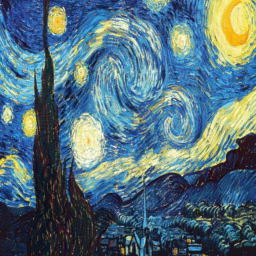

i=8000, score=0.98401, _nsfw_loss=0.82132, jpg_loss=36.92982, max_norm=9.881916, L2_norm=1471.189740
i=8100, score=0.98514, _nsfw_loss=0.80285, jpg_loss=35.18888, max_norm=9.998154, L2_norm=1482.193982
i=8200, score=0.98539, _nsfw_loss=0.76858, jpg_loss=34.77918, max_norm=10.112895, L2_norm=1492.792182
i=8300, score=0.98813, _nsfw_loss=0.69065, jpg_loss=35.21908, max_norm=10.219055, L2_norm=1503.822795
i=8400, score=0.98790, _nsfw_loss=0.84468, jpg_loss=35.26746, max_norm=10.320878, L2_norm=1514.934735
i=8500, score=0.98884, _nsfw_loss=0.78940, jpg_loss=34.68604, max_norm=10.423000, L2_norm=1525.448295
i=8600, score=0.99099, _nsfw_loss=0.81512, jpg_loss=35.21049, max_norm=10.529447, L2_norm=1535.651002
i=8700, score=0.99034, _nsfw_loss=0.78759, jpg_loss=36.40823, max_norm=10.646520, L2_norm=1545.838446
i=8800, score=0.99131, _nsfw_loss=0.79653, jpg_loss=35.52447, max_norm=10.764880, L2_norm=1555.407262
i=8900, score=0.99120, _nsfw_loss=0.80873, jpg_loss=35.63838, max_norm=10.876878, L2

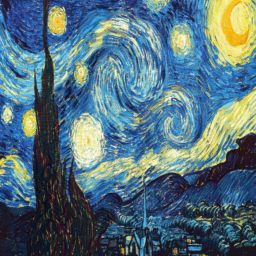

i=9000, score=0.99048, _nsfw_loss=0.78002, jpg_loss=34.49311, max_norm=10.974357, L2_norm=1573.350406
i=9100, score=0.99115, _nsfw_loss=0.64944, jpg_loss=35.86758, max_norm=11.058896, L2_norm=1582.285846
i=9200, score=0.99178, _nsfw_loss=0.76995, jpg_loss=36.03397, max_norm=11.124944, L2_norm=1591.161761
i=9300, score=0.99212, _nsfw_loss=0.80906, jpg_loss=36.00746, max_norm=11.174166, L2_norm=1599.945624
i=9400, score=0.99083, _nsfw_loss=0.79822, jpg_loss=34.54689, max_norm=11.220379, L2_norm=1608.299879
i=9500, score=0.98935, _nsfw_loss=0.80343, jpg_loss=34.72192, max_norm=11.265760, L2_norm=1616.953076
i=9600, score=0.98951, _nsfw_loss=0.83905, jpg_loss=34.27077, max_norm=11.305252, L2_norm=1625.734603


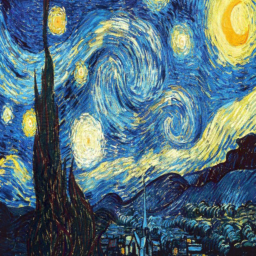

In [7]:
# the main process
try:
    for i in range(30000+1):
        img = input_image.get_value()
        if i%100 == 0:
            # save the result every 100 steps
            result_img = Image.fromarray(deprocess(img))
            result_img.save('{}-nsfw-{}.png'.format(output_fn, i))
            if i%1000 == 0:
                # check the result visually (it should not visually changed too much)
                display(result_img)

        # train the jpeg model
        jpg_target = crop(make_jpg(img))
        l_jpg, jpg = jpg_train_fn(jpg_target)

        # fit the inverse nsfw image
        # l is the loss; either the approximated NSFW score or 1 - approximated NSFW score, depends on the direction.
        l = _nsfw_train_fn()
        if i%100 == 0:
            # compare to original image
            max_norm = np.abs(img - pimg).max()
            l2_norm = np.sum((img - pimg)**2)**0.5
            # NSFW score
            score = nsfw_score_fn(jpg_target)
            print("i=%d, score=%.5f, _nsfw_loss=%.5f, jpg_loss=%.5f, max_norm=%f, L2_norm=%f"%(i, score, l, l_jpg, max_norm, l2_norm))
except KeyboardInterrupt:
    display(Image.fromarray(deprocess(img)))